#### **RQ4**
- How do the different interventions affect the cheating behavior, performance, and experience?


We use partial correlations in a psychological network analysis to estimate the relationships between different interventions, cheating behavior, performance, and experience. The model includes the below components for each cheating group:
- 5 mechanisms (need satisfaction, need frustration, self-efficacy, norm perception and cognitive discomfort), 
- 2 moderators (perceived ability and moral disengagement), 
- 2 outcomes (performance and experience),  
- 15 concepts

In [ ]:
# =============================================================================
# PSYCHOLOGICAL NETWORK ANALYSIS
# Comprehensive network model with mechanisms, moderators, outcomes, and concepts
# =============================================================================

import sys, os, warnings
sys.path.append('../')
warnings.filterwarnings('ignore')
os.chdir('game-behavior-analytics/data_analysis_notebook/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import StandardScaler

# Load and prepare data
df = pd.read_csv("../data/final_dataset.csv")

def categorize_cheating(rate):
    return 0 if rate == 0 else 2 if rate == 1 else 1

# Create analysis variables
df['cheating_behavior'] = df['cheating_rate_main_round'].apply(categorize_cheating)
df['experience'] = (df['task_satisfaction'] + df['task_engagement']) / 2
df['performance'] = df['performance_score_including_cheated_words']
df = df.dropna(subset=['cheating_behavior', 'performance', 'experience', 'concept'])

In [6]:
# =============================================================================
# 1. NETWORK DATA PREPARATION
# =============================================================================

def prepare_comprehensive_network_data(df):
    """Prepare comprehensive network data with mechanisms, moderators, outcomes, and concepts"""
    
    # Create one-hot encoding for concepts first
    df_work = df.copy()
    for concept in df_work['concept'].unique():
        if concept != 'control':
            df_work[f'concept_{concept}'] = (df_work['concept'] == concept).astype(int)
    
    # Encode gender as binary (1 for Male, 0 for Female)
    if 'gender' in df_work.columns:
        df_work['gender_numeric'] = (df_work['gender'] == 'Male').astype(int)
    
    # Define variable groups
    network_vars = {
        # 5 Psychological Mechanisms
        'need_satisfaction': 'overall_need_satisfaction',
        'need_frustration': 'overall_need_frustration', 
        'self_efficacy': 'task_specific_self_efficacy',
        'norm_perception': 'norm_perception',
        'cognitive_discomfort': 'cognitive_discomfort',
        
        # 2 Moderators
        'perceived_ability': 'word_creation_skill_level',
        'moral_disengagement': 'moral_disengagement',
        
        # 3 Behavioral Outcomes
        'cheating': 'cheating_behavior',
        'performance': 'performance', 
        'experience': 'experience',
        
        # 15 Concepts (one-hot encoded)
        'autonomy': 'concept_autonomy',
        'competence': 'concept_competence',
        'relatedness': 'concept_relatedness',
        'self_concept': 'concept_self_concept',
        'cognitive_inconsistency': 'concept_cognitive_inconsistency',
        'dissonance_arousal': 'concept_dissonance_arousal',
        'dissonance_reduction': 'concept_dissonance_reduction',
        'performance_accomplishments': 'concept_performance_accomplishments',
        'vicarious_experience': 'concept_vicarious_experience',
        'verbal_persuasion': 'concept_verbal_persuasion',
        'emotional_arousal': 'concept_emotional_arousal',
        'descriptive_norms': 'concept_descriptive_norms',
        'injunctive_norms': 'concept_injunctive_norms',
        'social_sanctions': 'concept_social_sanctions',
        'reference_group_identification': 'concept_reference_group_identification'
    }
    
    # Select available variables
    available_vars = {}
    for key, var in network_vars.items():
        if var in df_work.columns:
            available_vars[key] = var
    
    network_data = df_work[list(available_vars.values())].copy()
    network_data.columns = list(available_vars.keys())
    
    # Remove any non-numeric columns and handle missing values
    network_data = network_data.select_dtypes(include=[np.number])
    network_data = network_data.fillna(network_data.mean())
    
    # Standardize all variables
    scaler = StandardScaler()
    network_data_scaled = pd.DataFrame(
        scaler.fit_transform(network_data),
        columns=network_data.columns,
        index=network_data.index
    )
    
    return network_data_scaled, list(network_data.columns)

def estimate_partial_correlations(data):
    """Estimate partial correlation matrix using Graphical Lasso"""
    
    try:
        model = GraphicalLassoCV(cv=5, max_iter=1000, alphas=20)
        model.fit(data)
        
        # Convert precision to partial correlations
        precision = model.precision_
        diag_sqrt = np.sqrt(np.diag(precision))
        partial_corr = -precision / np.outer(diag_sqrt, diag_sqrt)
        np.fill_diagonal(partial_corr, 0)
        
        return partial_corr, model.alpha_
    except:
        # Fallback to simple correlation if Graphical Lasso fails
        corr_matrix = data.corr().values
        np.fill_diagonal(corr_matrix, 0)
        return corr_matrix, None

def calculate_network_metrics(matrix, labels, threshold=0.1):
    """Calculate comprehensive network metrics"""
    
    n_variables = len(labels)
    total_possible_edges = n_variables * (n_variables - 1) // 2
    
    # Count significant edges
    abs_matrix = np.abs(matrix)
    np.fill_diagonal(abs_matrix, 0)
    significant_edges = (abs_matrix > threshold).sum() // 2
    
    density = significant_edges / total_possible_edges
    
    # Average path length and clustering
    G = nx.Graph()
    for i in range(n_variables):
        G.add_node(i, label=labels[i])
    
    for i in range(n_variables):
        for j in range(i+1, n_variables):
            if abs(matrix[i, j]) > threshold:
                G.add_edge(i, j, weight=abs(matrix[i, j]))
    
    if len(G.edges()) > 0:
        clustering = nx.average_clustering(G)
        if nx.is_connected(G):
            avg_path_length = nx.average_shortest_path_length(G)
        else:
            avg_path_length = np.inf
    else:
        clustering = 0
        avg_path_length = np.inf
    
    return {
        'density': density,
        'n_edges': significant_edges,
        'clustering': clustering,
        'avg_path_length': avg_path_length,
        'n_nodes': n_variables
    }


In [7]:
# =============================================================================
# 2. NETWORK ANALYSIS
# =============================================================================

print("=" * 70)
print("COMPREHENSIVE PSYCHOLOGICAL NETWORK ANALYSIS")
print("=" * 70)

# Prepare network data
network_data, labels = prepare_comprehensive_network_data(df)
print(f"Network variables (n={len(labels)}): {labels}")
print(f"Sample size: {len(network_data)}")

# Estimate partial correlations
partial_corr_matrix, alpha = estimate_partial_correlations(network_data)
print(f"Regularization parameter (alpha): {alpha}")

# Calculate network metrics
threshold = 0.1
metrics = calculate_network_metrics(partial_corr_matrix, labels, threshold)

print("\nNETWORK METRICS:")
print(f"Density: {metrics['density']:.3f}")
print(f"Number of edges (|r| > {threshold}): {metrics['n_edges']}")
print(f"Average clustering: {metrics['clustering']:.3f}")
print(f"Average path length: {metrics['avg_path_length']:.3f}")


COMPREHENSIVE PSYCHOLOGICAL NETWORK ANALYSIS
Network variables (n=25): ['need_satisfaction', 'need_frustration', 'self_efficacy', 'norm_perception', 'cognitive_discomfort', 'perceived_ability', 'moral_disengagement', 'cheating', 'performance', 'experience', 'autonomy', 'competence', 'relatedness', 'self_concept', 'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction', 'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal', 'descriptive_norms', 'injunctive_norms', 'social_sanctions', 'reference_group_identification']
Sample size: 1232
Regularization parameter (alpha): 0.0005385297607962345

NETWORK METRICS:
Density: 0.397
Number of edges (|r| > 0.1): 119
Average clustering: 0.741
Average path length: inf


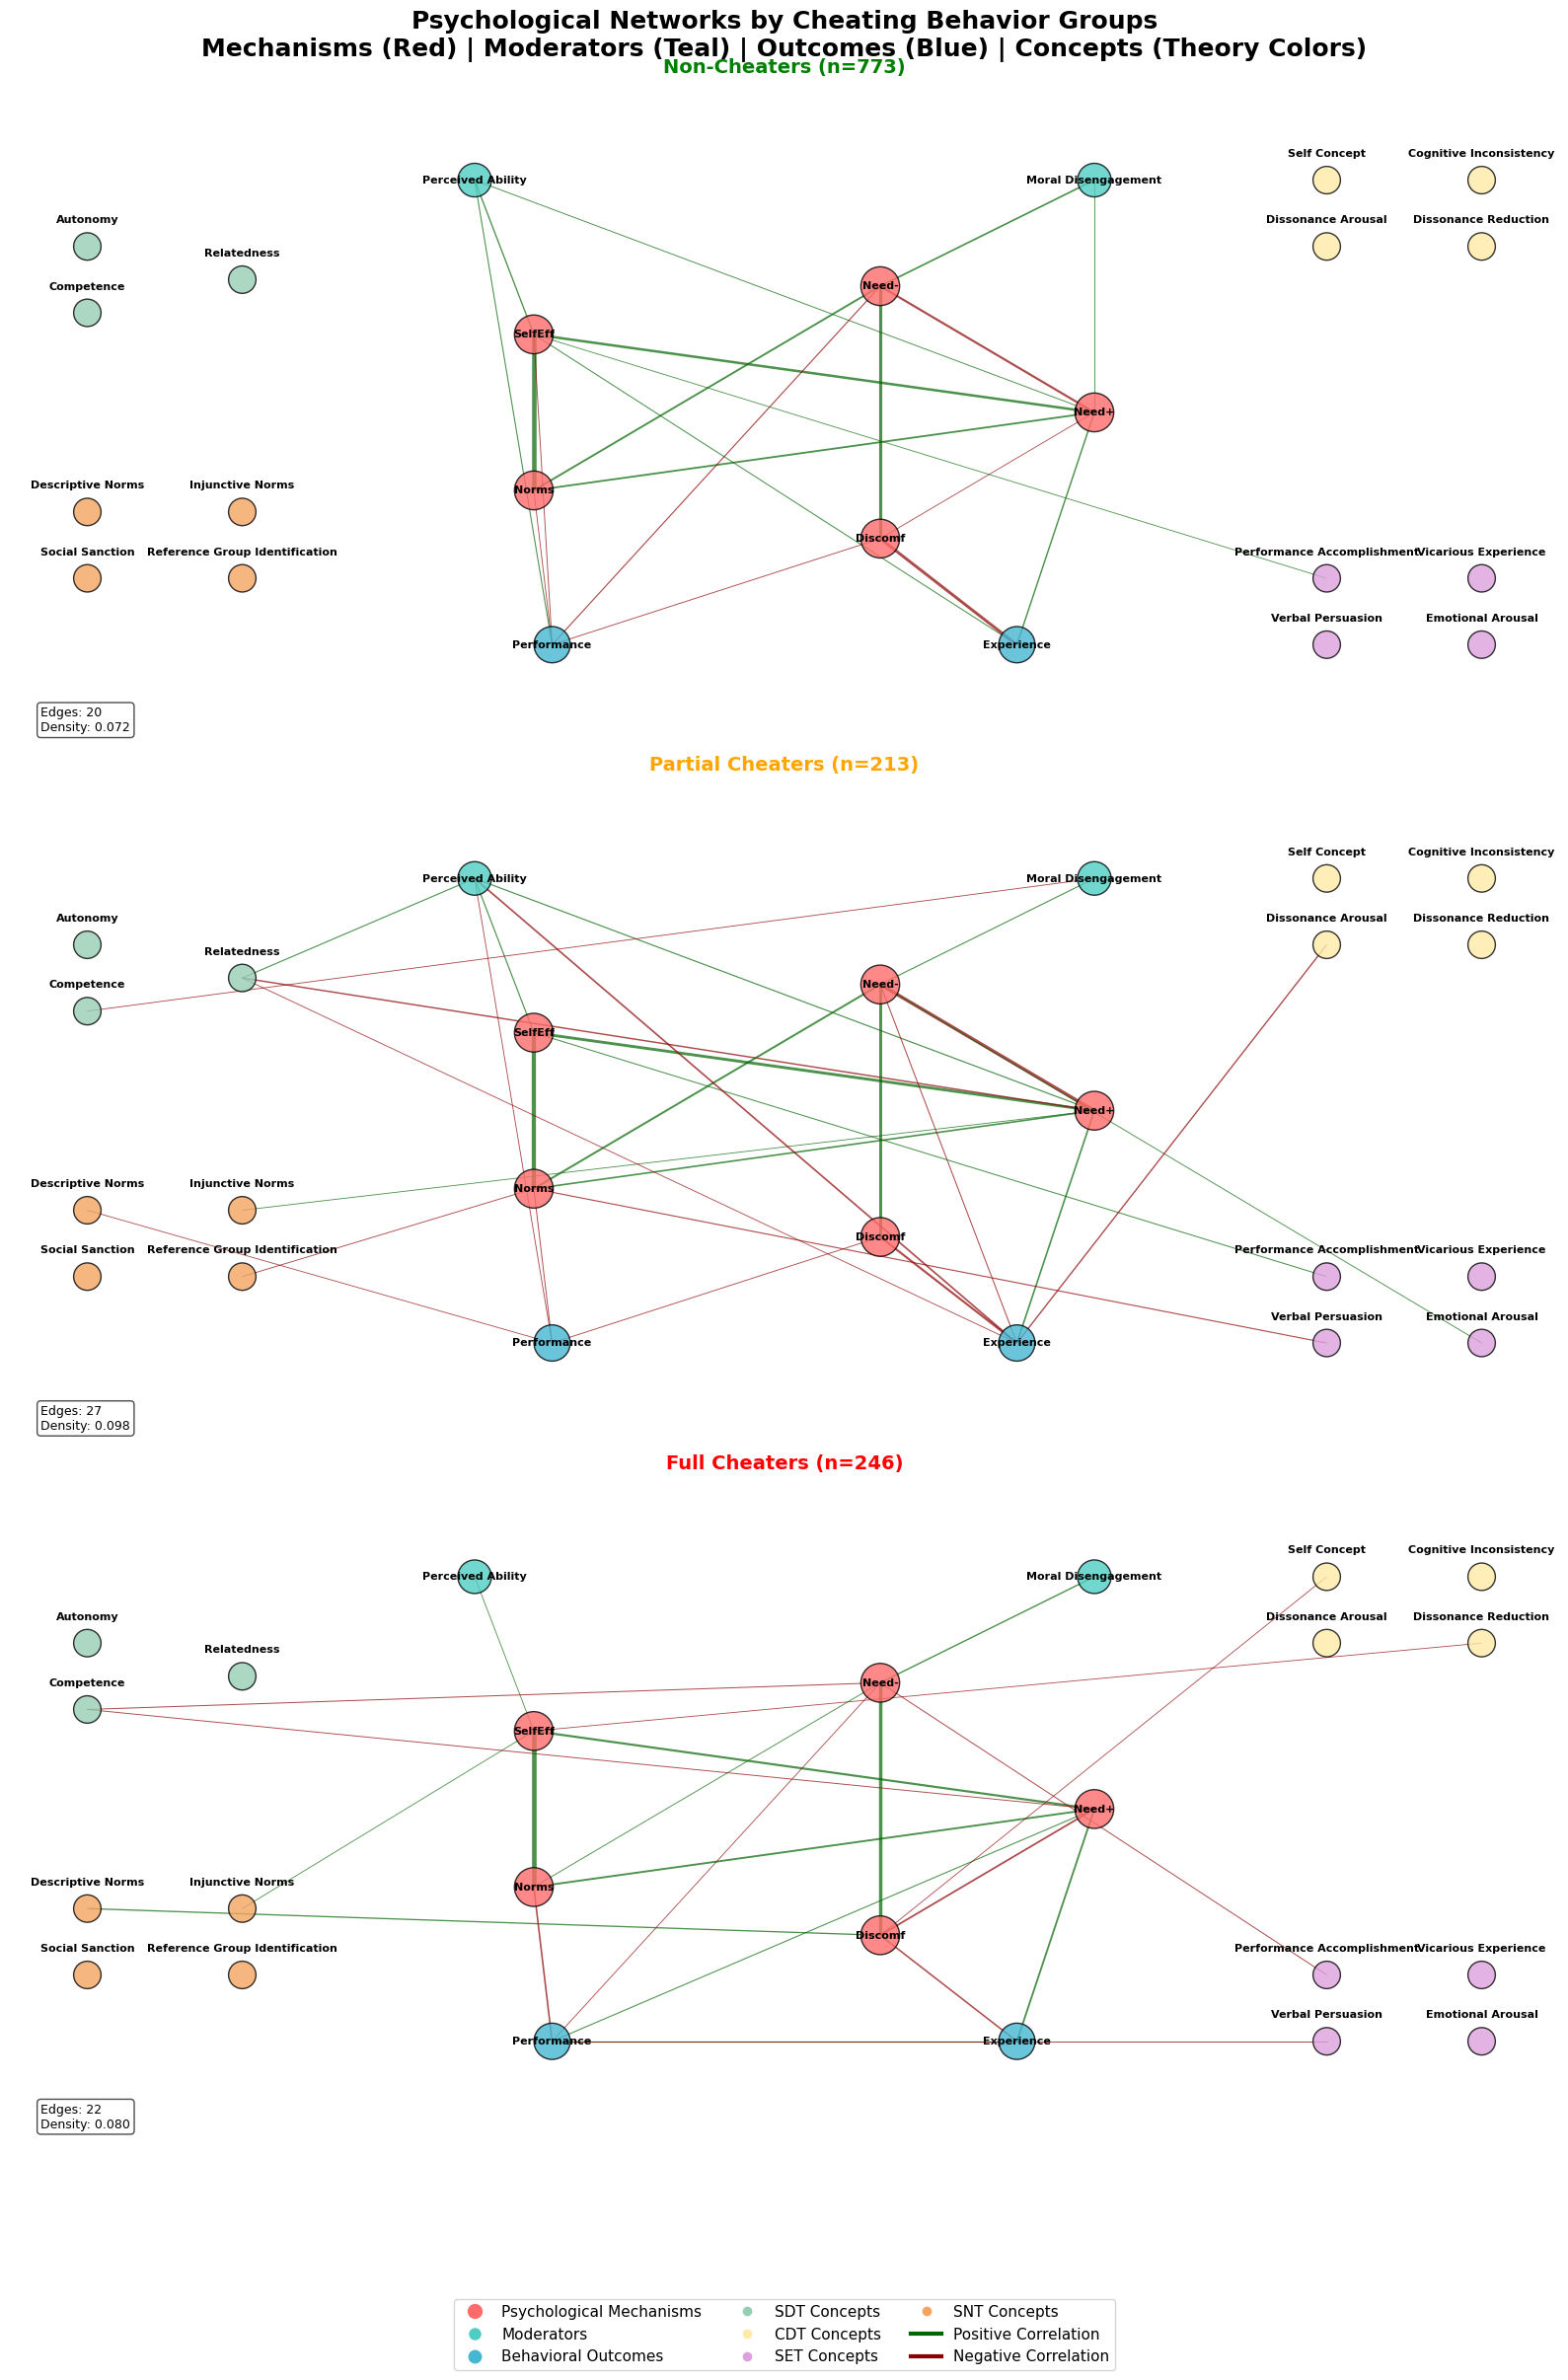

<Figure size 640x480 with 0 Axes>

In [19]:
# =============================================================================
# 3. NETWORK VISUALIZATION BY CHEATING GROUPS
# =============================================================================

def create_cheating_group_networks(df, threshold=0.05):
    """Create separate network plots for each cheating behavior group"""
    
    fig, axes = plt.subplots(3, 1, figsize=(16, 24))
    cheating_groups = [0, 1, 2]
    group_names = ['Non-Cheaters', 'Partial Cheaters', 'Full Cheaters']
    group_colors = ['green', 'orange', 'red']
    
    for idx, (group, name, color) in enumerate(zip(cheating_groups, group_names, group_colors)):
        ax = axes[idx]
        
        # Filter data for this cheating group
        group_data = df[df['cheating_behavior'] == group]
        
        if len(group_data) < 10:
            ax.text(0.5, 0.5, f'{name}\nInsufficient Data\n(n={len(group_data)})', 
                   ha='center', va='center', fontsize=14, transform=ax.transAxes)
            ax.set_title(name, fontsize=16, fontweight='bold', color=color)
            ax.axis('off')
            continue
        
        # Prepare network data for this group
        network_data, labels = prepare_comprehensive_network_data(group_data)
        
        # Remove 'cheating' from outcomes since we're grouping by it
        labels = [l for l in labels if l != 'cheating']
        if 'cheating' in network_data.columns:
            network_data = network_data.drop('cheating', axis=1)
        
        # Estimate partial correlations
        partial_corr_matrix, _ = estimate_partial_correlations(network_data)
        
        # Create network plot for this group
        create_single_network_plot(ax, partial_corr_matrix, labels, threshold, name, color, len(group_data))
    
    # Add legend at bottom
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF6B6B', 
                  markersize=12, label='Psychological Mechanisms'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4ECDC4', 
                  markersize=10, label='Moderators'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#45B7D1', 
                  markersize=11, label='Behavioral Outcomes'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#96CEB4', 
                  markersize=8, label='SDT Concepts'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FFEAA7', 
                  markersize=8, label='CDT Concepts'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#DDA0DD', 
                  markersize=8, label='SET Concepts'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#F4A460', 
                  markersize=8, label='SNT Concepts'),
        plt.Line2D([0], [0], color='darkgreen', linewidth=3, label='Positive Correlation'),
        plt.Line2D([0], [0], color='darkred', linewidth=3, label='Negative Correlation')
    ]
    
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.02), 
               ncol=3, fontsize=11, frameon=True)
    
    plt.suptitle('Psychological Networks by Cheating Behavior Groups\nMechanisms (Red) | Moderators (Teal) | Outcomes (Blue) | Concepts (Theory Colors)', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, bottom=0.08)
    plt.show()

def create_single_network_plot(ax, matrix, labels, threshold, group_name, group_color, n_participants):
    """Create a single network plot for one cheating group"""
    
    # Define node groups (without cheating)
    mechanisms = ['need_satisfaction', 'need_frustration', 'self_efficacy', 'norm_perception', 'cognitive_discomfort']
    moderators = ['perceived_ability', 'moral_disengagement']
    outcomes = ['performance', 'experience']  # Removed 'cheating'
    
    # Concept groups by theory
    sdt_concepts = ['autonomy', 'competence', 'relatedness']
    cdt_concepts = ['self_concept', 'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction']
    set_concepts = ['performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal']
    snt_concepts = ['descriptive_norms', 'injunctive_norms', 'social_sanctions', 'reference_group_identification']
    
    # Create fixed positions
    pos = {}
    
    # Central mechanisms (circle)
    if any(m in labels for m in mechanisms):
        mech_angles = np.linspace(0, 2*np.pi, len(mechanisms), endpoint=False)
        for i, mech in enumerate(mechanisms):
            if mech in labels:
                idx = labels.index(mech)
                pos[idx] = (0.5 + 0.2 * np.cos(mech_angles[i]), 
                           0.5 + 0.2 * np.sin(mech_angles[i]))
    
    # Moderators (top)
    mod_x_positions = np.linspace(0.3, 0.7, len(moderators))
    for i, mod in enumerate(moderators):
        if mod in labels:
            idx = labels.index(mod)
            pos[idx] = (mod_x_positions[i], 0.85)
    
    # Outcomes (bottom) - only 2 now
    out_x_positions = np.linspace(0.35, 0.65, len(outcomes))
    for i, out in enumerate(outcomes):
        if out in labels:
            idx = labels.index(out)
            pos[idx] = (out_x_positions[i], 0.15)
    
    # Concepts arranged by theory (corners)
    concept_positions = {
        'sdt': [(0.05, 0.75), (0.05, 0.65), (0.15, 0.70)],
        'cdt': [(0.85, 0.85), (0.95, 0.85), (0.85, 0.75), (0.95, 0.75)],
        'set': [(0.85, 0.25), (0.95, 0.25), (0.85, 0.15), (0.95, 0.15)],
        'snt': [(0.05, 0.35), (0.15, 0.35), (0.05, 0.25), (0.15, 0.25)]
    }
    
    for i, concept in enumerate(sdt_concepts):
        if concept in labels and i < len(concept_positions['sdt']):
            idx = labels.index(concept)
            pos[idx] = concept_positions['sdt'][i]
    
    for i, concept in enumerate(cdt_concepts):
        if concept in labels and i < len(concept_positions['cdt']):
            idx = labels.index(concept)
            pos[idx] = concept_positions['cdt'][i]
    
    for i, concept in enumerate(set_concepts):
        if concept in labels and i < len(concept_positions['set']):
            idx = labels.index(concept)
            pos[idx] = concept_positions['set'][i]
    
    for i, concept in enumerate(snt_concepts):
        if concept in labels and i < len(concept_positions['snt']):
            idx = labels.index(concept)
            pos[idx] = concept_positions['snt'][i]
    
    # Create network graph
    G = nx.Graph()
    for i, label in enumerate(labels):
        if i in pos:
            G.add_node(i, label=label)
    
    # Add filtered edges
    core_vars = mechanisms + moderators + outcomes
    concepts = [l for l in labels if l not in core_vars]
    
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            if i in pos and j in pos:
                weight = matrix[i, j]
                if abs(weight) > threshold:
                    label_i = labels[i]
                    label_j = labels[j]
                    
                    # Allow core-core and concept-core connections only
                    if ((label_i in core_vars and label_j in core_vars) or 
                        (label_i in concepts and label_j in core_vars) or
                        (label_i in core_vars and label_j in concepts)):
                        G.add_edge(i, j, weight=weight)
    
    # Node colors and sizes
    node_colors = []
    node_sizes = []
    for node in G.nodes():
        label = labels[node]
        if label in mechanisms:
            node_colors.append('#FF6B6B')
            node_sizes.append(800)
        elif label in moderators:
            node_colors.append('#4ECDC4')
            node_sizes.append(600)
        elif label in outcomes:
            node_colors.append('#45B7D1')
            node_sizes.append(700)
        elif label in sdt_concepts:
            node_colors.append('#96CEB4')
            node_sizes.append(400)
        elif label in cdt_concepts:
            node_colors.append('#FFEAA7')
            node_sizes.append(400)
        elif label in set_concepts:
            node_colors.append('#DDA0DD')
            node_sizes.append(400)
        elif label in snt_concepts:
            node_colors.append('#F4A460')
            node_sizes.append(400)
        else:
            node_colors.append('#D3D3D3')
            node_sizes.append(300)
    
    # Draw edges
    if G.edges():
        edge_weights = []
        edge_colors = []
        for u, v in G.edges():
            weight = G[u][v]['weight']
            edge_weights.append(abs(weight) * 6)
            edge_colors.append('darkred' if weight < 0 else 'darkgreen')
        
        nx.draw_networkx_edges(G, pos, ax=ax, width=edge_weights, 
                             edge_color=edge_colors, alpha=0.7)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, ax=ax, 
                         node_color=node_colors,
                         node_size=node_sizes, 
                         alpha=0.8, edgecolors='black', linewidths=1)
    
    # Draw labels
    label_dict = {}
    label_pos = {}
    for node in G.nodes():
        label = labels[node]
        if label in mechanisms:
            abbrev_map = {
                'need_satisfaction': 'Need+',
                'need_frustration': 'Need-',
                'self_efficacy': 'SelfEff',
                'norm_perception': 'Norms',
                'cognitive_discomfort': 'Discomf'
            }
            label_dict[node] = abbrev_map.get(label, label[:6])
            label_pos[node] = pos[node]
        elif label in outcomes + moderators:
            label_dict[node] = label.replace('_', ' ').title()
            label_pos[node] = pos[node]
        else:
            concept_abbrev = {
                'autonomy': 'Autonomy', 'competence': 'Competence', 'relatedness': 'Relatedness',
                'self_concept': 'Self Concept', 'cognitive_inconsistency': 'Cognitive Inconsistency', 
                'dissonance_arousal': 'Dissonance Arousal', 'dissonance_reduction': 'Dissonance Reduction',
                'performance_accomplishments': 'Performance Accomplishment', 'vicarious_experience': 'Vicarious Experience',
                'verbal_persuasion': 'Verbal Persuasion', 'emotional_arousal': 'Emotional Arousal',
                'descriptive_norms': 'Descriptive Norms', 'injunctive_norms': 'Injunctive Norms',
                'social_sanctions': 'Social Sanction', 'reference_group_identification': 'Reference Group Identification',
                'perceived_ability': 'Perceived Ability', 'moral_disengagement': 'Moral Disengagement'
            }
            label_dict[node] = concept_abbrev.get(label, label[:6])
            # Move label above the node
            x, y = pos[node]
            label_pos[node] = (x, y + 0.04)  # Offset upward
    
    nx.draw_networkx_labels(G, label_pos, labels=label_dict, ax=ax, 
                          font_size=8, font_weight='bold')
    
    # Title and stats
    ax.set_title(f'{group_name} (n={n_participants})', fontsize=14, fontweight='bold', color=group_color)
    
    if G.edges():
        density = len(G.edges()) / (len(labels) * (len(labels) - 1) / 2) if len(labels) > 1 else 0
        ax.text(0.02, 0.02, f'Edges: {len(G.edges())}\nDensity: {density:.3f}', 
               transform=ax.transAxes, fontsize=9, 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

def create_comprehensive_network_plot(matrix, labels, threshold=0.1):
    """Create comprehensive network plot with grouped layout"""
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 16))
    
    # Define node groups and their properties
    mechanisms = ['need_satisfaction', 'need_frustration', 'self_efficacy', 'norm_perception', 'cognitive_discomfort']
    moderators = ['age', 'gender']
    outcomes = ['cheating', 'performance', 'experience']
    
    # Concept groups by theory
    sdt_concepts = ['autonomy', 'competence', 'relatedness']
    cdt_concepts = ['self_concept', 'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction']
    set_concepts = ['performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal']
    snt_concepts = ['descriptive_norms', 'injunctive_norms', 'social_sanctions', 'reference_group_identification']
    
    # Create fixed positions for better layout
    pos = {}
    
    # Central mechanisms (circle)
    if any(m in labels for m in mechanisms):
        mech_angles = np.linspace(0, 2*np.pi, len(mechanisms), endpoint=False)
        for i, mech in enumerate(mechanisms):
            if mech in labels:
                idx = labels.index(mech)
                pos[idx] = (0.5 + 0.15 * np.cos(mech_angles[i]), 
                           0.5 + 0.15 * np.sin(mech_angles[i]))
    
    # Moderators (top)
    mod_x_positions = np.linspace(0.3, 0.7, len(moderators))
    for i, mod in enumerate(moderators):
        if mod in labels:
            idx = labels.index(mod)
            pos[idx] = (mod_x_positions[i], 0.9)
    
    # Outcomes (bottom)
    out_x_positions = np.linspace(0.3, 0.7, len(outcomes))
    for i, out in enumerate(outcomes):
        if out in labels:
            idx = labels.index(out)
            pos[idx] = (out_x_positions[i], 0.1)
    
    # Concepts arranged by theory (corners and sides)
    # SDT concepts (top-left)
    for i, concept in enumerate(sdt_concepts):
        if concept in labels:
            idx = labels.index(concept)
            pos[idx] = (0.05 + i * 0.08, 0.75 - i * 0.05)
    
    # CDT concepts (top-right)
    for i, concept in enumerate(cdt_concepts):
        if concept in labels:
            idx = labels.index(concept)
            pos[idx] = (0.85 + (i % 2) * 0.08, 0.8 - (i // 2) * 0.08)
    
    # SET concepts (bottom-right)
    for i, concept in enumerate(set_concepts):
        if concept in labels:
            idx = labels.index(concept)
            pos[idx] = (0.85 + (i % 2) * 0.08, 0.3 - (i // 2) * 0.08)
    
    # SNT concepts (bottom-left)
    for i, concept in enumerate(snt_concepts):
        if concept in labels:
            idx = labels.index(concept)
            pos[idx] = (0.05 + (i % 2) * 0.08, 0.35 - (i // 2) * 0.08)
    
    # Create network graph
    G = nx.Graph()
    for i, label in enumerate(labels):
        if i in pos:  # Only add nodes that have positions
            G.add_node(i, label=label)
    
    # Add significant edges with restrictions
    edge_list = []
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            if i in pos and j in pos:  # Only connect positioned nodes
                weight = matrix[i, j]
                if abs(weight) > threshold:
                    label_i = labels[i]
                    label_j = labels[j]
                    
                    # Define allowed connections
                    core_vars = mechanisms + moderators + outcomes
                    concepts = [l for l in labels if l not in core_vars]
                    
                    # Allow connections if:
                    # 1. Both are core variables (mechanisms, moderators, outcomes)
                    # 2. One is concept and other is core variable
                    # Exclude: concept-to-concept connections
                    
                    if ((label_i in core_vars and label_j in core_vars) or 
                        (label_i in concepts and label_j in core_vars) or
                        (label_i in core_vars and label_j in concepts)):
                        G.add_edge(i, j, weight=weight)
                        edge_list.append((i, j, weight))
    
    # Node colors and sizes by group
    node_colors = []
    node_sizes = []
    for node in G.nodes():
        label = labels[node]
        if label in mechanisms:
            node_colors.append('#FF6B6B')  # Red for mechanisms
            node_sizes.append(1200)
        elif label in moderators:
            node_colors.append('#4ECDC4')  # Teal for moderators
            node_sizes.append(800)
        elif label in outcomes:
            node_colors.append('#45B7D1')  # Blue for outcomes
            node_sizes.append(1000)
        elif label in sdt_concepts:
            node_colors.append('#96CEB4')  # Green for SDT
            node_sizes.append(600)
        elif label in cdt_concepts:
            node_colors.append('#FFEAA7')  # Yellow for CDT
            node_sizes.append(600)
        elif label in set_concepts:
            node_colors.append('#DDA0DD')  # Purple for SET
            node_sizes.append(600)
        elif label in snt_concepts:
            node_colors.append('#F4A460')  # Orange for SNT
            node_sizes.append(600)
        else:
            node_colors.append('#D3D3D3')  # Gray for others
            node_sizes.append(400)
    
    # Draw edges with thickness and color based on correlation strength
    if G.edges():
        edge_weights = []
        edge_colors = []
        for u, v in G.edges():
            weight = G[u][v]['weight']
            edge_weights.append(abs(weight) * 8)  # Scale edge thickness
            edge_colors.append('darkred' if weight < 0 else 'darkgreen')
        
        nx.draw_networkx_edges(G, pos, ax=ax, width=edge_weights, 
                             edge_color=edge_colors, alpha=0.7)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, ax=ax, 
                         node_color=node_colors,
                         node_size=node_sizes, 
                         alpha=0.8, edgecolors='black', linewidths=1)
    
    # Draw labels with abbreviated names
    label_dict = {}
    for node in G.nodes():
        label = labels[node]
        if label in mechanisms:
            abbrev_map = {
                'need_satisfaction': 'Need+',
                'need_frustration': 'Need-',
                'self_efficacy': 'SelfEff',
                'norm_perception': 'Norms',
                'cognitive_discomfort': 'Discomf'
            }
            label_dict[node] = abbrev_map.get(label, label[:6])
        elif label in outcomes:
            label_dict[node] = label.title()
        elif label in moderators:
            label_dict[node] = label.title()
        else:
            # Concept abbreviations
            concept_abbrev = {
                'autonomy': 'Auto', 'competence': 'Comp', 'relatedness': 'Relate',
                'self_concept': 'SelfC', 'cognitive_inconsistency': 'CogInc', 
                'dissonance_arousal': 'DisAr', 'dissonance_reduction': 'DisRed',
                'performance_accomplishments': 'PerfAcc', 'vicarious_experience': 'VicExp',
                'verbal_persuasion': 'VerbP', 'emotional_arousal': 'EmoAr',
                'descriptive_norms': 'DescN', 'injunctive_norms': 'InjN',
                'social_sanctions': 'SocSan', 'reference_group_identification': 'RefGrp'
            }
            label_dict[node] = concept_abbrev.get(label, label[:6])
    
    nx.draw_networkx_labels(G, pos, labels=label_dict, ax=ax, 
                          font_size=9, font_weight='bold')
    
    # Add group labels
    ax.text(0.02, 0.85, 'Self-Determination\nTheory', fontsize=12, fontweight='bold', 
           bbox=dict(boxstyle='round', facecolor='#96CEB4', alpha=0.7), transform=ax.transAxes)
    
    ax.text(0.85, 0.85, 'Cognitive\nDissonance\nTheory', fontsize=12, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='#FFEAA7', alpha=0.7), transform=ax.transAxes)
    
    ax.text(0.85, 0.15, 'Self-Efficacy\nTheory', fontsize=12, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='#DDA0DD', alpha=0.7), transform=ax.transAxes)
    
    ax.text(0.02, 0.15, 'Social Norms\nTheory', fontsize=12, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='#F4A460', alpha=0.7), transform=ax.transAxes)
    
    ax.text(0.5, 0.95, 'MODERATORS', fontsize=14, fontweight='bold', ha='center',
           bbox=dict(boxstyle='round', facecolor='#4ECDC4', alpha=0.7), transform=ax.transAxes)
    
    ax.text(0.5, 0.65, 'MECHANISMS', fontsize=14, fontweight='bold', ha='center',
           bbox=dict(boxstyle='round', facecolor='#FF6B6B', alpha=0.7), transform=ax.transAxes)
    
    ax.text(0.5, 0.02, 'OUTCOMES', fontsize=14, fontweight='bold', ha='center',
           bbox=dict(boxstyle='round', facecolor='#45B7D1', alpha=0.7), transform=ax.transAxes)
    
    # Network statistics
    stats_text = f"""Network Statistics:
Nodes: {len(G.nodes())}
Edges: {len(G.edges())}
Density: {metrics['density']:.3f}
Clustering: {metrics['clustering']:.3f}"""
    
    ax.text(0.98, 0.5, stats_text, fontsize=11, 
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
           transform=ax.transAxes, verticalalignment='center', horizontalalignment='right')
    
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.axis('off')
    
    return fig, ax

# Create network plots by cheating groups (lowered threshold)
threshold = 0.1
create_cheating_group_networks(df, threshold)

# Enhanced legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF6B6B', 
              markersize=15, label='Psychological Mechanisms'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4ECDC4', 
              markersize=12, label='Moderators'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#45B7D1', 
              markersize=13, label='Behavioral Outcomes'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#96CEB4', 
              markersize=10, label='SDT Concepts'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FFEAA7', 
              markersize=10, label='CDT Concepts'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#DDA0DD', 
              markersize=10, label='SET Concepts'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#F4A460', 
              markersize=10, label='SNT Concepts'),
    plt.Line2D([0], [0], color='darkgreen', linewidth=4, label='Positive Correlation'),
    plt.Line2D([0], [0], color='darkred', linewidth=4, label='Negative Correlation')
]

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), 
           ncol=3, fontsize=12, frameon=True)

plt.suptitle('Comprehensive Psychological Network: Mechanisms, Moderators, Outcomes & Concepts\n' +
             'Center: Core Mechanisms | Corners: Theory-Based Concepts | Top: Moderators | Bottom: Outcomes', 
             fontsize=18, fontweight='bold', y=0.95)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, top=0.85)
plt.show()

In [15]:
# =============================================================================
# 4. DETAILED CORRELATION ANALYSIS
# =============================================================================

print("\n" + "=" * 70)
print("STRONGEST CORRELATIONS BY VARIABLE TYPE")
print("=" * 70)

# Function to find strongest correlations
def analyze_correlations_by_type(matrix, labels, threshold=0.15):
    """Analyze strongest correlations by variable type"""
    
    # Define variable groups
    mechanisms = ['need_satisfaction', 'need_frustration', 'self_efficacy', 'norm_perception', 'cognitive_discomfort']
    moderators = ['perceived_ability', 'moral_disengagement']
    outcomes = ['performance', 'experience']  # Removed cheating
    concepts = [label for label in labels if label not in mechanisms + moderators + outcomes]
    
    results = {}
    
    # Mechanism-Outcome correlations
    mech_outcome_corrs = []
    for mech in mechanisms:
        if mech in labels:
            for outcome in outcomes:
                if outcome in labels:
                    mech_idx = labels.index(mech)
                    outcome_idx = labels.index(outcome)
                    corr = matrix[mech_idx, outcome_idx]
                    if abs(corr) > threshold:
                        mech_outcome_corrs.append((mech, outcome, corr))
    
    mech_outcome_corrs.sort(key=lambda x: abs(x[2]), reverse=True)
    results['mechanism_outcome'] = mech_outcome_corrs[:10]
    
    # Concept-Mechanism correlations
    concept_mech_corrs = []
    for concept in concepts:
        if concept in labels:
            for mech in mechanisms:
                if mech in labels:
                    concept_idx = labels.index(concept)
                    mech_idx = labels.index(mech)
                    corr = matrix[concept_idx, mech_idx]
                    if abs(corr) > threshold:
                        concept_mech_corrs.append((concept, mech, corr))
    
    concept_mech_corrs.sort(key=lambda x: abs(x[2]), reverse=True)
    results['concept_mechanism'] = concept_mech_corrs[:10]
    
    # Moderator effects (moderators to mechanisms/outcomes/concepts)
    moderator_corrs = []
    for mod in moderators:
        if mod in labels:
            for other in mechanisms + outcomes + concepts:
                if other in labels and other != mod:
                    mod_idx = labels.index(mod)
                    other_idx = labels.index(other)
                    corr = matrix[mod_idx, other_idx]
                    if abs(corr) > threshold:
                        moderator_corrs.append((mod, other, corr))
    
    moderator_corrs.sort(key=lambda x: abs(x[2]), reverse=True)
    results['moderator'] = moderator_corrs[:10]
    
    return results

# Analyze correlations
correlation_analysis = analyze_correlations_by_type(partial_corr_matrix, labels)

# Print results
print("\nTOP MECHANISM → OUTCOME CORRELATIONS:")
for mech, outcome, corr in correlation_analysis['mechanism_outcome']:
    print(f"  {mech} → {outcome}: {corr:+.3f}")

print("\nTOP CONCEPT → MECHANISM CORRELATIONS:")
for concept, mech, corr in correlation_analysis['concept_mechanism']:
    print(f"  {concept} → {mech}: {corr:+.3f}")

print("\nTOP MODERATOR CORRELATIONS:")
for mod, other, corr in correlation_analysis['moderator']:
    print(f"  {mod} ↔ {other}: {corr:+.3f}")


STRONGEST CORRELATIONS BY VARIABLE TYPE

TOP MECHANISM → OUTCOME CORRELATIONS:
  cognitive_discomfort → experience: -0.296
  need_satisfaction → experience: +0.192

TOP CONCEPT → MECHANISM CORRELATIONS:

TOP MODERATOR CORRELATIONS:
  moral_disengagement ↔ need_frustration: +0.182


In [16]:
# =============================================================================
# 5. NETWORK SUMMARY
# =============================================================================

print("\n" + "=" * 70)
print("NETWORK ANALYSIS SUMMARY")
print("=" * 70)

print(f"Total variables in network: {len(labels)}")
print(f"- Psychological mechanisms: {len([l for l in labels if l in ['need_satisfaction', 'need_frustration', 'self_efficacy', 'norm_perception', 'cognitive_discomfort']])}")
print(f"- Moderators: {len([l for l in labels if l in ['perceived_ability', 'moral_disengagement']])}")
print(f"- Behavioral outcomes: {len([l for l in labels if l in ['performance', 'experience']])}")
print(f"- Intervention concepts: {len([l for l in labels if l not in ['need_satisfaction', 'need_frustration', 'self_efficacy', 'norm_perception', 'cognitive_discomfort', 'perceived_ability', 'moral_disengagement', 'performance', 'experience']])}")

print(f"\nNetwork connectivity (threshold = {threshold}):")
print(f"- Network density: {metrics['density']:.3f}")
print(f"- Total edges: {metrics['n_edges']}")
print(f"- Average clustering: {metrics['clustering']:.3f}")

print(f"\nKey findings:")
print(f"- Most connected mechanisms: {[c[0] for c in correlation_analysis['mechanism_outcome'][:3]]}")
print(f"- Strongest moderator effects: {[c[0] for c in correlation_analysis['moderator'][:2]]}")
print(f"- Most influential concepts: {[c[0] for c in correlation_analysis['concept_mechanism'][:3]]}")

print("\n✓ Comprehensive psychological network analysis completed")
print("✓ Network captures relationships between mechanisms, moderators, outcomes, and intervention concepts")


NETWORK ANALYSIS SUMMARY
Total variables in network: 25
- Psychological mechanisms: 5
- Moderators: 2
- Behavioral outcomes: 2
- Intervention concepts: 16

Network connectivity (threshold = 0.1):
- Network density: 0.397
- Total edges: 119
- Average clustering: 0.741

Key findings:
- Most connected mechanisms: ['cognitive_discomfort', 'need_satisfaction']
- Strongest moderator effects: ['moral_disengagement']
- Most influential concepts: []

✓ Comprehensive psychological network analysis completed
✓ Network captures relationships between mechanisms, moderators, outcomes, and intervention concepts
